In [91]:
import pandas as pd

# Load the dataset
file_path = 'ad_views_without_engagement.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
df.head()


,u_userId,u_phonePrice,u_browserLifeCycle,u_browserMode,u_feedLifeCycle,u_refreshTimes,u_newsCatInterests,u_newsCatDislike,u_newsCatInterestsST,u_click_ca2_news,...,e_ch,e_m,e_po,e_pl,e_rn,e_section,e_et,label,cillabel,pro
0,135880,16,17,10,17,0,195^168^109^98^108,0,195^44^168^112^21,195^168^44^112^21,...,19,1217,1,561,2,0,202206081521,-1,-1,0
1,135880,16,17,10,17,0,195^168^109^98^108,0,195^44^168^112^21,195^168^44^112^21,...,19,1217,9,561,1,0,202206081521,-1,-1,0
2,135880,16,17,10,17,0,195^168^109^98^108,0,195^44^168^112^21,195^168^44^112^21,...,19,1217,18,561,1,0,202206081521,-1,-1,0
3,135880,16,17,10,17,0,195^168^109^98^108,0,195^44^168^112^21,195^168^44^112^21,...,19,1217,7,561,1,1,202206081521,-1,-1,0
4,135880,16,17,10,17,0,195^168^109^98^108,0,195^44^168^112^21,195^168^44^112^21,...,19,1217,7,561,2,0,202206081522,-1,-1,0


/var/folders/kp/5sffjpx16mn8zwj4605fht_00000gn/T/ipykernel_34039/514704491.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['e_et'] = pd.to_datetime(df_relevant['e_et'], format='%Y%m%d%H%M')


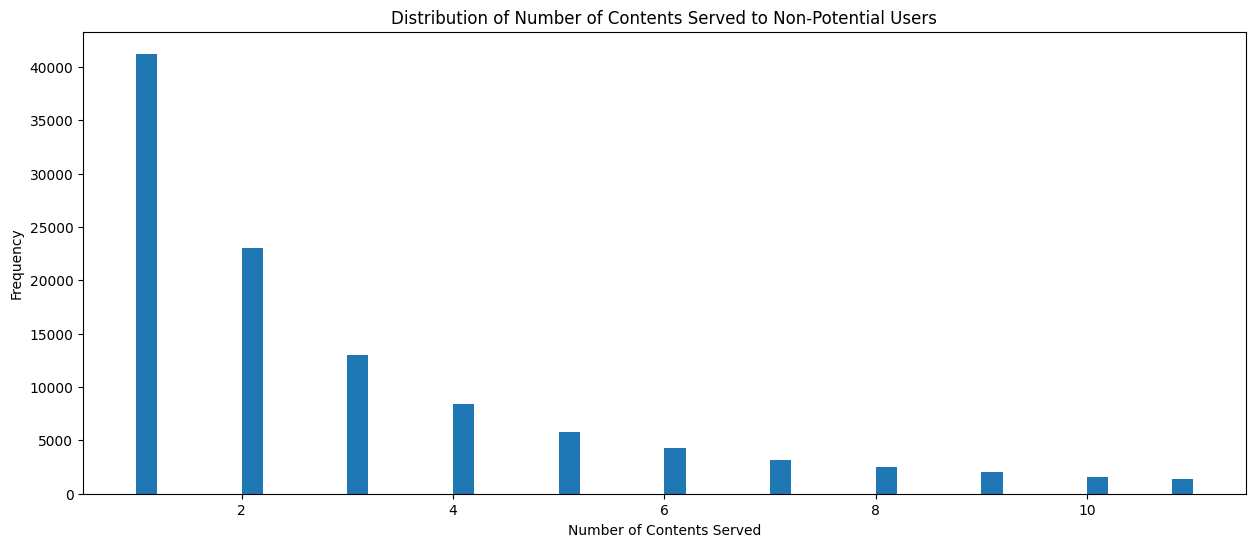

In [161]:
# Extract relevant columns for analysis
relevant_columns = ['u_userId', 'e_et', 'label']
df_relevant = df[relevant_columns]

# Convert e_et to datetime format
df_relevant['e_et'] = pd.to_datetime(df_relevant['e_et'], format='%Y%m%d%H%M')

# Calculate the number of content served to each user
content_counts = df_relevant.groupby('u_userId').size()
Q1 = content_counts.quantile(0.25)
Q3 = content_counts.quantile(0.75)
IQR = Q3 - Q1
lower_bound=0
#lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_content_counts = content_counts[(content_counts >= lower_bound) & (content_counts <= upper_bound)]

# Plot the distribution of the number of contents served
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
filtered_content_counts.hist(bins=50)
plt.title('Distribution of Number of Contents Served to Non-Potential Users')
plt.xlabel('Number of Contents Served')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()




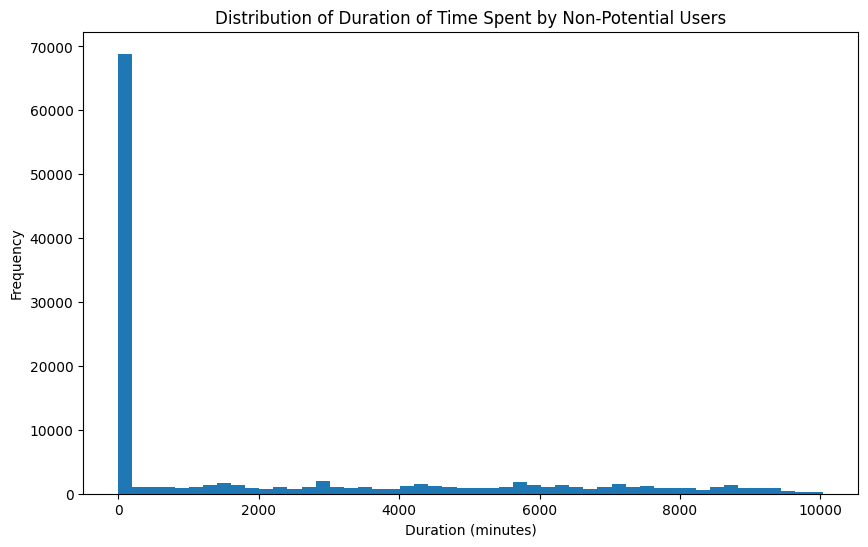

,min,max,duration
u_userId,,,
100001,2022-06-05 09:20:00,2022-06-05 09:28:00,8.0
100003,2022-06-03 17:19:00,2022-06-03 17:27:00,8.0
100007,2022-06-04 21:14:00,2022-06-09 14:25:00,6791.0
100011,2022-06-03 22:17:00,2022-06-09 09:28:00,7871.0
100012,2022-06-03 09:20:00,2022-06-03 09:21:00,1.0
...,...,...,...
287178,2022-06-07 13:21:00,2022-06-07 13:21:00,0.0
287181,2022-06-07 21:16:00,2022-06-09 10:26:00,2230.0
287182,2022-06-03 22:28:00,2022-06-09 23:28:00,8700.0


In [146]:
# Calculate the time difference for each user
time_diff = df_relevant.groupby('u_userId')['e_et'].agg(['min', 'max'])
time_diff['duration'] = (time_diff['max'] - time_diff['min']).dt.total_seconds() / 60  # duration in minutes

# Plot the distribution of the durations
plt.figure(figsize=(10, 6))
time_diff['duration'].hist(bins=50)
plt.title('Distribution of Duration of Time Spent by Non-Potential Users')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# Display the time duration
time_diff

Most frequent total time spent (mode): 1.0
time_diff
1.0       5184
2.0       2046
3.0       1228
4.0        965
5.0        697
          ... 
5697.0      34
176.0       34
1503.0      34
5821.0      34
4383.0      34
Name: count, Length: 100, dtype: int64


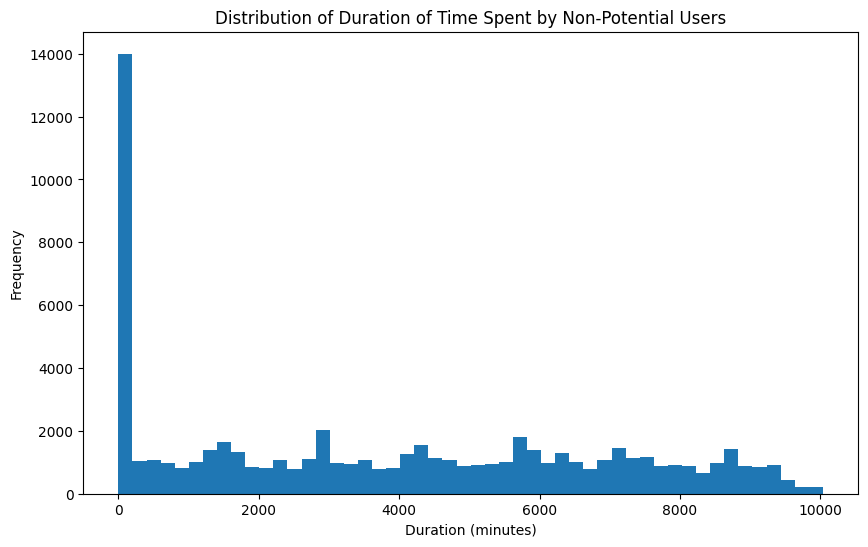

In [157]:
df_relevant = df_relevant.sort_values(by=['u_userId', 'e_et'])

# 計算相鄰兩次投放之間的時間差

df_relevant['time_diff'] = df_relevant.groupby('u_userId')['e_et'].diff().dt.total_seconds() / 60
df_relevant = df_relevant.dropna(subset=['time_diff'])
df_relevant = df_relevant[df_relevant['time_diff'] != 0]
total_time_spent = df_relevant.groupby('u_userId')['time_diff'].sum()
most_frequent_total_time_spent = total_time_spent.mode()[0]

print("Most frequent total time spent (mode):", most_frequent_total_time_spent)


print(total_time_spent.value_counts().head(100))
plt.figure(figsize=(10, 6))
total_time_spent.hist(bins=50)
plt.title('Distribution of Duration of Time Spent by Non-Potential Users')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


In [158]:
average_duration = total_time_spent.mean()
average_duration

3780.2236191006373

In [162]:
# Calculate the click-through rate (CTR)
clicks = df_relevant[df_relevant['label'] == 1].groupby('u_userId').size()
total_served = df_relevant.groupby('u_userId').size()
ctr = clicks / total_served
overall_ctr = clicks.sum() / total_served.sum()
ctr
overall_ctr

0.06976888587624412

/var/folders/kp/5sffjpx16mn8zwj4605fht_00000gn/T/ipykernel_34039/3452374632.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['e_et'] = pd.to_datetime(df_relevant['e_et'], format='%Y%m%d%H%M')
/var/folders/kp/5sffjpx16mn8zwj4605fht_00000gn/T/ipykernel_34039/3452374632.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['hour'] = df_relevant['e_et'].dt.hour


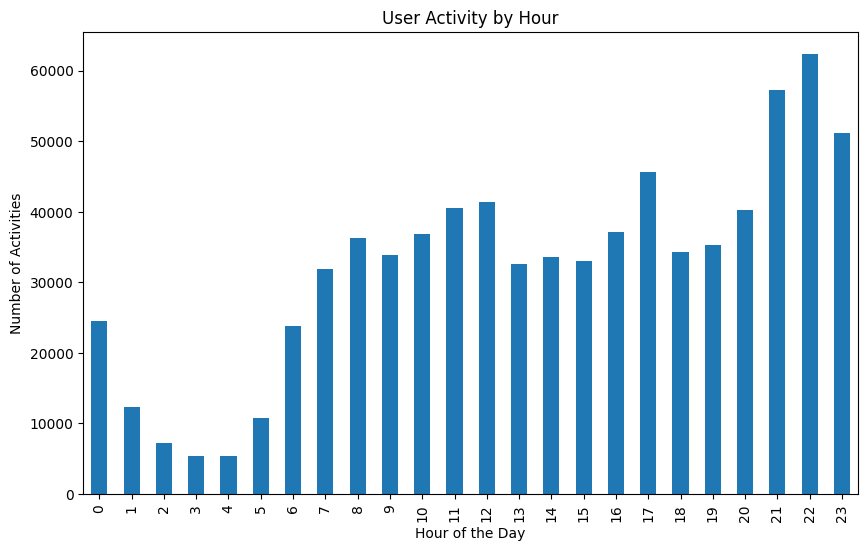

In [170]:
file_path = 'ad_views_without_engagement.csv'
df = pd.read_csv(file_path)

# 提取相關欄位並轉換時間格式
df_relevant = df[['u_userId', 'e_et', 'label']]
df_relevant['e_et'] = pd.to_datetime(df_relevant['e_et'], format='%Y%m%d%H%M')

# 提取小時信息
df_relevant['hour'] = df_relevant['e_et'].dt.hour

# 計算每個小時的活躍度
hourly_activity = df_relevant.groupby('hour').size()

# 繪製每小時的活躍度分佈圖
plt.figure(figsize=(10, 6))
hourly_activity.plot(kind='bar')
plt.title('User Activity by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Activities')
plt.grid(False)
plt.show()


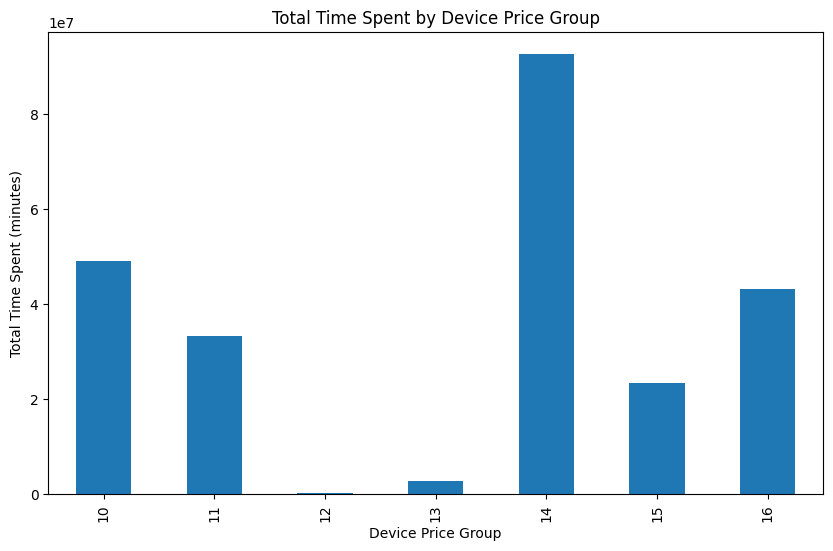

In [172]:
df_relevant = df_relevant.sort_values(by=['u_userId', 'e_et'])

# 計算相鄰兩次投放之間的時間差
df_relevant['time_diff'] = df_relevant.groupby('u_userId')['e_et'].diff().dt.total_seconds() / 60

# 去除第一行的 NaN 值，因為第一行沒有前一行可比較
#df_relevant = df_relevant.dropna(subset=['time_diff'])

# 刪除時間差為0的行
df_relevant = df_relevant[df_relevant['time_diff'] != 0]

# 設備價格分組，每個數字作為一個分組
df_relevant['device_price_group'] = df['u_phonePrice']

# 計算不同設備價格群組的總花費時間
device_price_group_time_spent = df_relevant.groupby('device_price_group')['time_diff'].sum()

# 繪製不同設備價格群組的總花費時間分佈圖
plt.figure(figsize=(10, 6))
device_price_group_time_spent.plot(kind='bar')
plt.title('Total Time Spent by Device Price Group')
plt.xlabel('Device Price Group')
plt.ylabel('Total Time Spent (minutes)')
plt.grid(False)
plt.show()


/var/folders/kp/5sffjpx16mn8zwj4605fht_00000gn/T/ipykernel_34039/1159524948.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(filtered_content_type_stats.index, rotation=90)


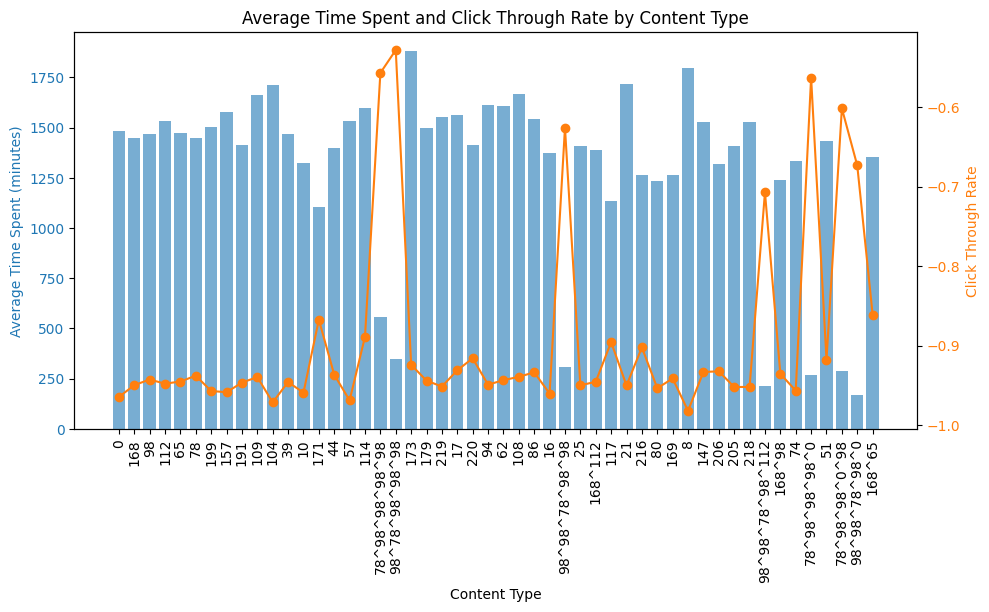

In [195]:
# 假設有一個內容類型欄位 'content_type'
df_relevant['content_type'] = df['u_newsCatInterests']

# 計算不同內容類型的平均花費時間和點擊率
content_type_stats = df_relevant.groupby('content_type').agg({'time_diff': 'mean', 'label': 'mean'})

# 過濾掉出現次數少的內容類型，僅保留出現次數最多的前10個內容類型
top_content_types = df_relevant['content_type'].value_counts().head(50).index
filtered_content_type_stats = content_type_stats.loc[top_content_types]

# 繪製不同內容類型的平均花費時間和點擊率分佈圖
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Content Type')
ax1.set_ylabel('Average Time Spent (minutes)', color='tab:blue')
ax1.bar(filtered_content_type_stats.index, filtered_content_type_stats['time_diff'], color='tab:blue', alpha=0.6, label='Average Time Spent')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticklabels(filtered_content_type_stats.index, rotation=90)
ax2 = ax1.twinx()
ax2.set_ylabel('Click Through Rate', color='tab:orange')
ax2.plot(filtered_content_type_stats.index, filtered_content_type_stats['label'], color='tab:orange', marker='o', label='Click Through Rate')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Average Time Spent and Click Through Rate by Content Type')
plt.show()

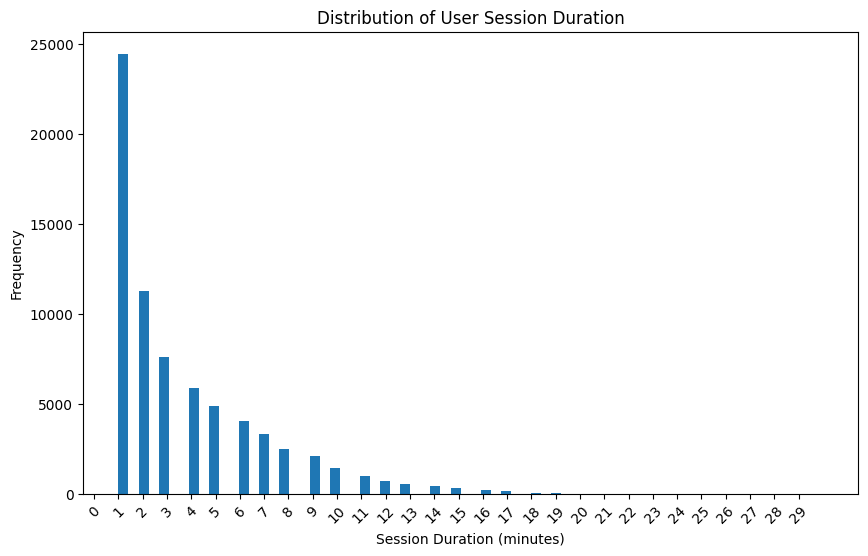

In [220]:
# 計算用戶持續活躍的時間段
df_relevant['session_id'] = (df_relevant['e_et'].diff().dt.total_seconds() > 18 * 60).cumsum()
user_sessions = df_relevant.groupby(['u_userId', 'session_id']).agg({'e_et': ['min', 'max']})

# 計算每個sessions的持續時間
user_sessions['session_duration'] = (user_sessions['e_et']['max'] - user_sessions['e_et']['min']).dt.total_seconds() / 60
user_sessions = user_sessions[user_sessions['session_duration'] > 0]
# 繪製用戶持續活躍時間的分佈圖
plt.figure(figsize=(10, 6))
user_sessions['session_duration'].hist(bins=70)
plt.title('Distribution of User Session Duration')
plt.xlabel('Session Duration (minutes)')
plt.ylabel('Frequency')
xticks = range(0, int(user_sessions['session_duration'].max()) , 1)
plt.xticks(xticks, rotation=45)
plt.grid(False)
plt.show()


/var/folders/kp/5sffjpx16mn8zwj4605fht_00000gn/T/ipykernel_34039/4169458591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['e_et'] = pd.to_datetime(df_relevant['e_et'], format='%Y%m%d%H%M')


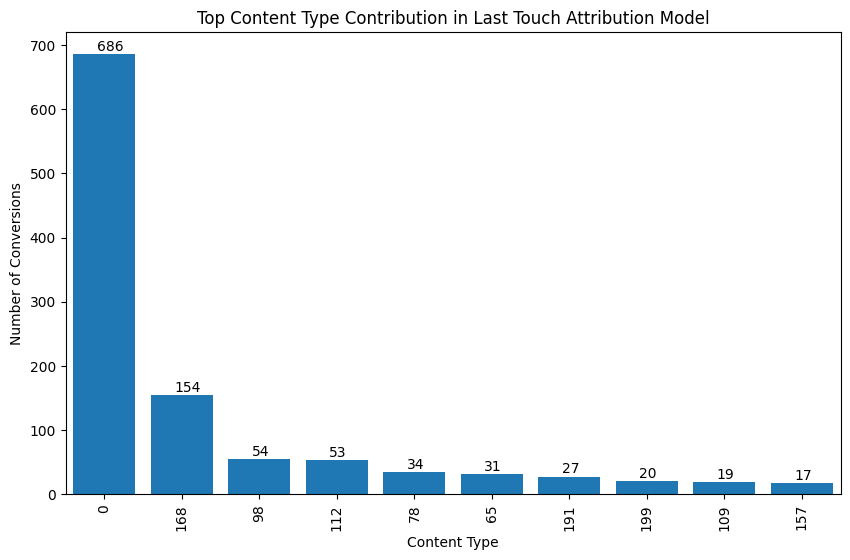

In [219]:

df_relevant = df[['u_userId', 'e_et', 'u_newsCatInterests', 'label']]
df_relevant['e_et'] = pd.to_datetime(df_relevant['e_et'], format='%Y%m%d%H%M')

# 按用戶分組並排序時間戳
df_relevant = df_relevant.sort_values(by=['u_userId', 'e_et'])

# 尋找每個用戶的最後一次接觸點
last_touch = df_relevant.groupby('u_userId').tail(1)

# 僅考慮轉化（點擊）的接觸點
last_touch_clicks = last_touch[last_touch['label'] == 1]

# 計算每個內容類型在轉化中的貢獻
content_type_contribution = last_touch_clicks['u_newsCatInterests'].value_counts()

# 過濾出現次數最多的前10個內容類型
top_content_types = content_type_contribution.head(10)

# 繪製內容類型在轉化中的貢獻
plt.figure(figsize=(10, 6))
bars = plt.bar(top_content_types.index, top_content_types.values)
top_content_types.plot(kind='bar')
plt.title('Top Content Type Contribution in Last Touch Attribution Model')
plt.xlabel('Content Type')
plt.ylabel('Number of Conversions')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 1, int(yval), va='bottom')
plt.grid(False)
plt.show()
